# Basic Reddit Analysis with PRAW
### Pranav Salunke
All code is in one notebook though when creating it, they were in different python files. This notbeook will be broken up into parts

 **configR.py**
 
 **info.py** <- will not work in the notbook until configR has stuff in it
 
 **infoStream.py** <- will not work in the notbook until configR has stuff in it
 
 **analyze.py**
 
 All data sets collected are in the folder or a sub folder

*disclaimer: some weirdly titled posts were scraped. If you see any..ignore those*


## configR.py

In [ ]:
# this will have your reddit user name, client id, secret, etc. In order for it to work, the Nones should be replaced by the real string values
client_id=None
client_secret=None
username=None
password=None
submitSub = None
user_agent=None

## info.py

In [ ]:
# all the imports

import os # used to modify files
import sys # detect system
import time # waiting 
import configR # the above file
import praw # the bulk of scraping with reddit
from praw.models import MoreComments
import datetime # to keep track of time
import traceback # error logging
if sys.platform == "win32": # only on my laptop (ran long ones on raspberry pi which is unix)
    import winsound # used to notify me when long runs were done 

In [ ]:
# utility helper functions

# used to detect if local machine is utc (like rpi vs laptop)
def localTimeIsUTC():
    # returns true if local time is utc time
    now = datetime.datetime.now()
    nowutc = datetime.datetime.utcnow()
    nowformated = now.strftime("%A %m/%d/%Y %H:%M")  # example: Thursday 01/24/2019 12:14
    nowutcformated = nowutc.strftime("%A %m/%d/%Y %H:%M")

    return (nowformated == nowutcformated)  # if equal, local time is utc

# when wanting to wait until a particular time to start (not used for this project)
def waitUntil(timestr, mintoWaitWhileStarting, postXdays):
    # example timestr = "03/31/19 23:48:18"
    # example mintoWaitWhileStarting = 120
    # example postXdays = 5 (post every 5 days)
    waitTime = datetime.datetime.strptime(timestr, "%x %X")

    twelveHoursBefore = (datetime.datetime.strptime(timestr, "%x %X")-datetime.timedelta(hours=12))
    oneMinBefore = (datetime.datetime.strptime(timestr, "%x %X") - datetime.timedelta(minutes=1))
    started = False
    startcounter = 0
    startCounterLim = (postXdays*24*60)/mintoWaitWhileStarting  # post every 5 days
    while not started:
        now = datetime.datetime.now() - datetime.timedelta(hours=7)  # local to home

        if now >= waitTime: # check if the current time has passed the time we were waiting until 
            print("IT HAS STARTED now is %s" % (str(now)))
            started = True
            break

        if not started:
            if twelveHoursBefore < now and now < oneMinBefore: # if with in 12 hours of the time, sleep for less amount
                time.sleep(30)  # 30 sec
            elif now > oneMinBefore: # check every second until the time starts 
                time.sleep(1)
            else:
                if startcounter >= startCounterLim:
                    startcounter = 0
                    # configR.submitSub is a subreddit (probaby private for dev use)
                    reddit.subreddit(configR.submitSub).submit(title='still waiting for info to start', selftext="%s" % (str(now)))
                startcounter = startcounter + 1

                time.sleep(mintoWaitWhileStarting*60) # sleep for the given time until checking again 

                
# number of iterations to do
def numberiterations(totalhours, interval): #ex total hours = 1 so 60 min. if interval is 10, thats 6 iterations 
    # interval in min
    totalmin = totalhours * 60.0
    return (int(round(totalmin / float(interval))), totalmin)
                

In [ ]:
# configR is a custom py file to import that holds sensitive info 

# the reddit instance that lets us scrape reddit (doesnt work in notebook since all are set as None)
reddit = praw.Reddit(client_id=configR.client_id,
                     client_secret=configR.client_secret,
                     username=configR.username,
                     password=configR.password,
                     user_agent=configR.user_agent)

In [ ]:
# the bulk of the script

# this is an iteration based system 

def info(totalDays, houroffset, interval, outfileName, writeToFile=False):
    errName = "info_error_log.txt"
    localIsUTC = localTimeIsUTC()
    # subsOfInterest = ["learnpython", "Python", "ucsc"]
    # subsOfInterest = ["learnpython"]
    # subsOfInterest = ["askreddit"]
    # subsOfInterest = ["popular"]
    subsOfInterest = ["ucsc"]

    with open(outfileName, "w") as outfile, open(errName, "a") as err:
        seenids = [] # keep track of posts ive seen
        breakpointid = "" 
        postslookedat = 0

        # find the total minutes/iterations required (ex: 100 min 20 iterations at 5 mim intervals)
        totalhours = (totaldays * 24.0) + hoursoffset
        iterations, totalmin = numberiterations(totalhours, interval)

        if not localIsUTC:  # tell err file when the run began
            utctime = datetime.datetime.utcnow()
            localtime = datetime.datetime.now()
            hometime = datetime.datetime.now()
            err.write("\n\n - %s (utc) | %s (local) | %s (home)\n" % (utctime, localtime, hometime))
            print("%s - %s (utc) | %s (local) | %s (home)" % (str(0), str(utctime.strftime("%x %X")),
                                                              str(localtime.strftime("%x %X")), str(hometime.strftime("%x %X"))))
        else:
            utctime = datetime.datetime.utcnow()
            localtime = datetime.datetime.now()
            hometime = datetime.datetime.now() - datetime.timedelta(hours=7)  # convert to local time

            err.write("\n\n - %s (utc) | %s (local) | %s (home)\n" % (utctime, localtime, hometime))
            print("%s - %s (utc) | %s (local) | %s (home)" % (str(0), str(utctime.strftime("%x %X")),
                                                              str(localtime.strftime("%x %X")), str(hometime.strftime("%x %X"))))

        # all data witten to csv file 
        if writeToFile:
            # write header
            outfile.write("Iteration Time (home),Iteration Time (utc),Post Time (utc),Subreddit,Title, Postid ,Author,Total Karma\n")
        for sub in subsOfInterest: # didnt really need this loop, oh well 
            for post in reddit.subreddit(sub).new(limit=25): # get the 25 newest posts  from the subreddit
                # get the real sub name
                #   if we use "all" or "popular" those arent 'real' subreddits
                #   if we use a 'real' name like 'askreddit' it will be the same
                realsub = post.subreddit.display_name.lower()  # extract subreddit from the post; this is the one that is put in the csv
                postid = post.id
                postslookedat = postslookedat + 1
                title = post.title
                # remove problematic chars from the title
                title = title.replace(",", "")  # so there aren't any comma issues when reading the csv
                title = title.replace("’", "")  # weird apostrophe
                title = title.replace("\"", "")  # quote
                title = title.replace("“", "")  # weird quote                

                if postid not in seenids: # if the post hasnt been seen yet, then save it 
                    # extract other info from the post
                    date = post.created_utc
                    minago = str(int(round(abs(date - time.time()) / 60)))
                    postauth = str(post.author)
                    authkarma = str(post.author.link_karma + post.author.comment_karma)

                    t = "placeholder title for %s" % (str(postid))
                    try: # errors happen on special chars like emojis 
                        #t = title.encode("cp437", "backslashreplace") + "   [[ " + str(minago) + "m - " + post.id + " ]]"
                        t = title
                        print(" " + str(t)) # print the title to the terminal 
                    except UnicodeDecodeError: # was not a unicode character
                        t = "placeholder title;   UnicodeDecodeError on %s" % (str(postid))
                        print("  UnicodeDecodeError on " + str(postid))
                    except: # some other error
                        t = "placeholder title;   Error on %s" % (str(postid))
                        print("  something went wrong on  " + str(postid))

                    # write row to csv file 
                    if writeToFile:
                        try:
                            outfile.write(str(hometime.strftime("%x %X")) + "," + str(utctime.strftime("%x %X")) + ",")
                            writedates = str(datetime.datetime.utcfromtimestamp(date).strftime("%x %X")) + ","
                            outfile.write(writedates + "\"" + realsub + "\"" + "," + "\"" + str(t) +
                                          "\"" + "," + postid + "," + postauth + "," + authkarma)
                            outfile.write("\n")
                        except UnicodeEncodeError:
                            # catch any uncode encode errors
                            # will be automatically removed later
                            outfile.write(",%s,UnicodeEncodeError \n" % (postid))  # for posts with special characters

                    seenids.append(postid)

                if breakpointid == "":
                    breakpointid = postid

        postid = ""
        print("total hours: %d (%d min). interval (min): %d. iterations: %d" %
              (totalhours, totalmin, interval, iterations))
        for i in range(1, iterations + 1): 
            # flush the file buffers at every iteration 
            err.flush()
            if writeToFile:
                outfile.flush()
            try:
                time.sleep(interval * 60) # wait for the interval 
                first = None # the first post looked at in this iteration 
                postslookedat = 0
                
                # get iteration time
                if not localIsUTC:
                    hometime = str(datetime.datetime.now().strftime("%x %X"))
                    utctime = str(datetime.datetime.utcnow().strftime("%x %X"))
                else:
                    hometime = str((datetime.datetime.now() -
                                    datetime.timedelta(hours=7)).strftime("%x %X"))
                    utctime = str(datetime.datetime.utcnow().strftime("%x %X"))

                for sub in subsOfInterest:
                    # THE REST IS MOSTLY THE SAME AS ABOVE
                    
                    for post in reddit.subreddit(sub).new(limit=250): # this time read 250 newest posts
                        realsub = post.subreddit.display_name.lower()  # this is the one that is put in the csv
                        postid = post.id
                        postslookedat = postslookedat + 1
                        if first is None:
                            first = postid

                        if postid == breakpointid: 
                            break  # caught up to the posts we saw

                        if postid not in seenids:
                            title = post.title
                            title = title.replace(",", "")  # so there aren't any comma issues when reading the csv
                            title = title.replace("’", "")  # weird apostrophe
                            title = title.replace("\"", "")  # quote
                            title = title.replace("“", "")  # weird quote
                                                        
                            postauth = str(post.author)
                            authkarma = str(post.author.link_karma + post.author.comment_karma)

                            date = post.created_utc
                            minago = str(int(round(abs(date - time.time()) / 60)))
                            t = "placeholder title for %s" % (str(postid))
                            try:
                                #t = title.encode("cp437", "backslashreplace")
                                t = title
                                print(" [[%s]] -- %s" % (realsub, t))
                            except UnicodeDecodeError:
                                t = "placeholder title;   UnicodeDecodeError on %s" % (str(postid))
                                print("  UnicodeDecodeError on " + str(postid))
                            except:
                                t = "placeholder title;   Error on %s" % (str(postid))
                                print("  something went wrong on  " + str(postid))
                            
                            # these excepts are important because I ran this on the raspberry pi and could not monitor it all the time. If an error happened, I did not want the whole thing to crash 

                            if writeToFile:
                                try:
                                    outfile.write(hometime + "," + utctime + ",")  # write iterations times
                                    writedates = str(datetime.datetime.utcfromtimestamp(date).strftime("%x %X")) + ","  # post time
                                    outfile.write(writedates + "\"" + realsub + "\"" + "," + "\"" + str(t) +
                                                  "\"" + "," + postid + "," + postauth + "," + authkarma)
                                    outfile.write("\n")
                                except UnicodeEncodeError:
                                    outfile.write(",%s,UnicodeEncodeError \n" % (postid))  # for posts with special characters

                            seenids.append(postid)

                    breakpointid = first # set the new breakpoint to be the first post we saw in this iteration 
            
            # these excepts are important because I ran this on the raspberry pi and could not monitor it all the time. If an error happened, I did not want the whole thing to crash 
            except KeyboardInterrupt:
                # if ctrlC out of the program, remove the file if needed and exit
                if not writeToFile:
                    os.remove(outfileName)
                exit()

            except Exception:
                # log any errors in the error log 
                
                print("ERROR CAUGHT. Check error log.")
                now = datetime.datetime.now() - datetime.timedelta(hours=7)  # local to home
                reddit.subreddit(configR.submitSub).submit(title="error in info at %s" %
                                                           (str(now)), selftext="ERROR CAUGHT (overall exception catch)\n")
                err.write("ERROR CAUGHT (overall exception catch) at %s\n" % (str(now)))
                err.write(traceback.format_exc())
                err.write("\n")

                if not writeToFile:
                    os.remove(outfileName)
                continue

    if not writeToFile:
        os.remove(outfileName)

In [ ]:
# the "main" program for info.py

def infoMain():
    # settings 
    writeToFile = True # if to write to the CSV file
    postToReddit = False # if to post to the subreddit for monitoring 
    
    totaldays = 0 # set how long to keep this running
    hoursoffset = 0.5
    interval = 5  # min, freqency of checking
    outfileName = "foo.csv" # csv to putput to 

    print("writeToFile: %s\npostToReddit: %s\noutfilename: %s" % (str(writeToFile), str(postToReddit), outfileName))
    time.sleep(5) # give me time to exit out 

    if postToReddit: # post to private subreddit to monitor away from raspberry pi
        startTime = datetime.datetime.now() - datetime.timedelta(hours=7)
        reddit.subreddit(configR.submitSub).submit(title='-->>-->> Start: %s' % (str(startTime)), selftext="info")

    # do the actual scraping now
    info(totaldays, hoursoffset, interval, outfileName, writeToFile)


    if postToReddit:
        endTime = datetime.datetime.now() - datetime.timedelta(hours=7)
        reddit.subreddit(configR.submitSub).submit(title='-->>-->> End: %s; \nElapsed: %s' %
                                                   (str(endTime), str(endTime-startTime)), selftext="info")

    if sys.platform == "win32": # notify me when done
        winsound.Beep(2250, 250)


In [ ]:
infoMain()

Problem with iteration system: if posts come in faster than the iteration frequency, we'll miss posts. Fix it with the stream in the next section 

## infoStream.py

Similar to the info.py but the main differnce is that there is a continuous stream of posts coming in as they are created

skipping the inputs and utility functions from above as they are the same

In [ ]:
# the bulk of the script

# this is a stream based system. Very similar to info.py main difference is noted below
# comments specific to the stream starts with "STREAM:"

def info(totalDays, houroffset, outfileName, writeToFile=False):
    streamStartTime = datetime.datetime.now()
    lastFileFlush = datetime.datetime.now()
    errName = "info_error_log.txt"
    localIsUTC = localTimeIsUTC()
    subOfInterest = "popular"

    with open(outfileName, "w") as outfile, open(errName, "a") as err:
        seenids = []
        breakpointid = ""
        postslookedat = 0

        totalhours = (totaldays * 24.0) + hoursoffset

        # NOTE: for the streamed data, Iteration Time (home) and Iteration Time (utc) is the time the stream was started

        if not localIsUTC:  # tell err file when the run began
            utctime = str(datetime.datetime.utcnow())
            localtime = str(datetime.datetime.now())
            hometime = str(datetime.datetime.now())
            err.write("\n\n - %s (utc) | %s (local) | %s (home)\n" % (utctime, localtime, hometime))
        else:
            utctime = str(datetime.datetime.utcnow())
            localtime = str(datetime.datetime.now())
            hometime = str(datetime.datetime.now() - datetime.timedelta(hours=7))  # convert to local time
            err.write("\n\n - %s (utc) | %s (local) | %s (home)\n" % (utctime, localtime, hometime))

        if writeToFile:
            # header for csv
            outfile.write("Iteration Time (home),Iteration Time (utc),Post Time (utc),Subreddit,Title, Postid ,Author,Total Karma\n")

        exceptCount = 0
        try:
            # make an open stream
            for post in reddit.subreddit(subOfInterest).stream.submissions(): # STREAM: MAIN DIFFERNCE IS HERE <-------
                realsub = post.subreddit.display_name.lower()  # this is the one that is put in the csv
                postid = post.id
                postslookedat = postslookedat + 1
                title = post.title
                title = title.replace(",", "")  # so there aren't any comma issues when reading the csv
                title = title.replace("’", "")  # weird apostrophe
                title = title.replace("\"", "")  # quote
                title = title.replace("“", "")  # weird quote

                # can assume post has not been seen before
                date = post.created_utc
                postauth = str(post.author)
                authkarma = str(post.author.link_karma + post.author.comment_karma)

                t = "placeholder title for %s" % (str(postid))
                try:
                    t = title
                    print(" [[%s]] -- %s" % (realsub, t))
                except UnicodeDecodeError:
                    t = "placeholder title;   UnicodeDecodeError on %s" % (str(postid))
                    print("  UnicodeDecodeError on " + str(postid))
                except:
                    t = "placeholder title;   Error on %s" % (str(postid))
                    print("  something went wrong on  " + str(postid))
                
                # these excepts are important because I ran this on the raspberry pi and could not monitor it all the time. If an error happened, I did not want the whole thing to crash 
                if writeToFile:
                    # write row 
                    try:
                        outfile.write(hometime + "," + utctime + ",")
                        writedates = str(datetime.datetime.utcfromtimestamp(date).strftime("%x %X")) + ","
                        outfile.write(writedates + "\"" + realsub + "\"" + "," + "\"" + str(t) +
                                      "\"" + "," + postid + "," + postauth + "," + authkarma)
                        outfile.write("\n")
                    except UnicodeEncodeError:
                        outfile.write(",%s,UnicodeEncodeError \n" % (postid))  # for posts with special characters

                nowtime = datetime.datetime.now()
                # flush file buffers every 1 min
                # STREAM: now with out an iteration, we cant flush the files very easily.
                # we have to wait for the buffer to fill or do this
                # for every posts that comes in, check if it has been over a minute since the file was flushed
                if nowtime > lastFileFlush + datetime.timedelta(minutes=1):
                    lastFileFlush = nowtime
                    err.flush()
                    if writeToFile:
                        outfile.flush()

                # check if it has been X hours since starting
                
                # STREAM: there is no end condition in this either.
                # so for every post that comes in, check if it has been X hours since starting 
                if nowtime > streamStartTime + datetime.timedelta(hours=totalhours):
                    print("\nIt has been %s hours. Ending stream listen" % (str(totalhours)))
                    # flush the file buffers
                    err.flush()
                    if writeToFile:
                        outfile.flush()
                    break
        
        # these excepts are important because I ran this on the raspberry pi and could not monitor it all the time. If an error happened, I did not want the whole thing to crash 
        except KeyboardInterrupt:
            err.flush()
            if writeToFile:
                outfile.flush()
            exit()
        except prawcore.exceptions.NotFound:
            # STREAM: this happned a lot when trying to stream on r/popular. My guess is that it was too fast
            # log it when this happens 
            exceptCount += 1 # STREAM: keep track of how many exceptions have been caught
            if not localIsUTC:
                errTime = str(datetime.datetime.now().strftime("%x %X"))
            else:
                errTime = str((datetime.datetime.now() - datetime.timedelta(hours=7)).strftime("%x %X"))
            print("Prawcore notfound ERROR CAUGHT. Check error log.")

            err.write("Prawcore notfound ERROR CAUGHT at %s\n" % (str(errTime)))
            err.write(traceback.format_exc())
            err.write("\n")        

            err.flush()
            if writeToFile:
                outfile.flush()
            
            # STREAM: exit the program if too many
            if exceptCount > 5: 
                # too many attempts
                print("too may attempts; exiting")
                err.write("too may attempts; exiting\n")
                exit()                
        except:
            # STREAM: general error, log this as well
            print("SOME ERROR :((")
            exceptCount += 1
            if not localIsUTC:
                errTime = str(datetime.datetime.now().strftime("%x %X"))
            else:
                errTime = str((datetime.datetime.now() - datetime.timedelta(hours=7)).strftime("%x %X"))

            print("ERROR CAUGHT. Check error log.")
            err.write("ERROR CAUGHT (overall exception catch) at %s\n" % (str(errTime)))
            err.write(traceback.format_exc())
            err.write("\n")

            err.flush()
            if writeToFile:
                outfile.flush()

            if exceptCount > 5:
                # too many attempts
                print("too may attempts; exiting")
                err.write("too may attempts; exiting\n")
                exit()

        else:
            # STREAM: reset the counter
            # no error
            exceptCount = 0

    if not writeToFile:
        os.remove(outfileName)

In [ ]:
# same as info main 

# demo on local 

def infoStreamMain():
    # note for some reason a stream for r/popular breaks (might be too fast?)
    totaldays = 0
    hoursoffset = 0.5
    outfileName = "test.csv"

    print("writeToFile: %s\npostToReddit: %s\noutfilename: %s" % (str(writeToFile), str(postToReddit), outfileName))
    time.sleep(5)

    if postToReddit:
        startTime = datetime.datetime.now() - datetime.timedelta(hours=7)
        reddit.subreddit(configR.submitSub).submit(title='-->>-->> Start: %s' % (str(startTime)), selftext="info")

    info(totaldays, hoursoffset, outfileName, writeToFile)
    
    if postToReddit:
        endTime = datetime.datetime.now() - datetime.timedelta(hours=7)
        reddit.subreddit(configR.submitSub).submit(title='-->>-->> End: %s; \nElapsed: %s' %
                                                   (str(endTime), str(endTime-startTime)), selftext="info")

    if sys.platform == "win32":
        winsound.Beep(2250, 250)


## analyze.py
#### This *will* work in this notebook! 

Now that all the data has been collected, we can analyze it! 

I was interested in frequencies and counts of various things

Files I'll be showing:
```
askreddit_2day12hour_interval5min.csv   ~ 6k  KB (didn't stop properly for some reason so closer to 3 days)
askreddit_2day12hour_stream.csv         ~ 4k  KB
Popular_2day12hour_interval5min.csv     ~ 13k KB (didn't stop properly for some reason so closer to 3 days)
popular_2day12hour_stream.csv           ~ 200 KB (this crashed when running for some reason, so not really 60 hours)
ucsc_2day12hour_interval5min.csv        ~ 35  KB
ucsc_2day12hour_stream.csv              ~ 18  KB 
```

Note: all of these were ran about the same time +/- 12 hours

In [9]:
# all the importsss

import datetime
import time
import csv # to read the csv I created
import pandas
import matplotlib.pyplot as plt # plotting
import matplotlib.dates as mdates
import os
import pickle # saving figures
from bokeh.plotting import figure, output_file, show # faster plotting for big data sets

In [10]:
# utility helper functions

# You can save matplotlib figures after building them

# the convention I chose to use when creating the name of the files
def creeatePickledName(filename, field):
    slashPos = filename.find("/")
    slashPos = slashPos if slashPos !=-1 else 0 # if no slash, start at beggining (0)
    dotPos = filename.find(".")
    pickleName = "pickledFigs/" + filename[slashPos:dotPos] + "__" + field + ".pickle"
    return pickleName

# create the pickle 
def createPickledFig(pickleName, fig):
    pickle.dump(fig, open(pickleName, "wb"))

# load the figure from a pickle (jar)
def loadPickledFig(figname):
    fig = pickle.load(open(figname, 'rb'))
    plt.show() 
    

In [11]:
# very important helper functions

# since the data was collected automatically, there may be issues with it 
# main issues are if an error is caught, the row may be missing information
#    special characters there could have come though, etc
# This method checks for these things
def preAnalyze(filename):
    print("doing Pre")
    count = 0
    badlines = []
    doAnalyze = True
    with open(filename, "r", encoding="ISO-8859-1") as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)
        numFields = len(header)
        linenum = 1
        for line in csvreader: 
            linenum += 1
            if len(line) != numFields:  # make sure there are the right number of elements as expected
                # print out the lines with the line number that are bad so I can go inspect them
                doAnalyze = False # signify that I should not continue 
                badlines.append(linenum)
                print("linenum:  "+str(linenum))
                print("linelen: %s/%s" % (str(len(line)), str(numFields)))
                print("line:  ")
                for l in line:
                    print(" ||" + str(l))
                print("----")
                count = count+1
    print("total bad: %d. lines:  %s" % (count, str(badlines)))
    return doAnalyze

# I got tired of inspecting the lines myself, so as any programmer would do... I automated it
def cleanFile(filename):
    print("cleaning UnicodeEncodeError")
    # splice the name and add __temp.csv to it 
    tempFilename = filename[:filename.find(".csv")] + "__temp.csv"  # ex "test.csv" -> "test__temp.csv"
    os.rename(filename, tempFilename) # create a copy of the file (that will be deleted)
    # allLines = None
    
    with open(tempFilename, "r", encoding="ISO-8859-1") as oldcsvfile:
        oldreader = csv.reader(oldcsvfile)
        with open(filename, "w", newline='', encoding="ISO-8859-1") as newcsvfile:
            newwriter = csv.writer(newcsvfile, delimiter=',')
            header = next(oldreader)
            numFields = len(header) # check the number of elments we expect
            newwriter.writerow(header) # write the header to the new file 
            # go through each line and only write the ones I want to keep
            for line in oldreader:
                line = [x.strip() for x in line] # remove whitespace from the lines for easier checking
                if "UnicodeEncodeError" in line: # from the error caught earlier. I use this to detect it's a line I dont want to keep
                    print("remove UnicodeEncodeError: %s"%(line))
                    continue

                if len(line) != numFields: # if the line is missing data or has too much data, skip it
                    print("remove incorrect line len: %s"%(line))
                    continue

                newwriter.writerow(line)

    os.remove(tempFilename)

    

In [13]:
# demonstrate the cleaning with this file: unclean file/uncleanData_6minPopularStream.csv
# note to self: unclean file/uncleanData_6minPopularStream_back.csv exists if anything goes very wrong

uncleanFile = "unclean file/uncleanData_6minPopularStream.csv"

# look at the first 5 lines of it, by some luck the first line has a EncodeError 
with open(uncleanFile,"r") as unclean: 
    header = next(unclean)
    for i in range(5):
        print(next(unclean))


05/07/19 01:37:33,05/07/19 08:37:33,,blo7l0,UnicodeEncodeError 

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:29,"theherald","Everything we know so far about missing woman Emma Faulds",blo7l3,boydie,732

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:29,"unlv","Scholarship ?",blo7l1,monikerlewinksy,1

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:30,"firefox","Cant get the new update on android kitakt",blo7l5,Kotee_ivanovich,11529

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:31,"theherald","Colleagues leap to defend BBC's Royal correspondent Nicholas Witchell after he cuts short live broadcast",blo7la,boydie,732



In [14]:
preAnalyze(uncleanFile) # notice there the output is false and the bad lines are printed

doing Pre
linenum:  2
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7l0
 ||UnicodeEncodeError 
----
linenum:  25
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7ml
 ||UnicodeEncodeError 
----
linenum:  35
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7ns
 ||UnicodeEncodeError 
----
linenum:  43
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7oe
 ||UnicodeEncodeError 
----
linenum:  79
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7qm
 ||UnicodeEncodeError 
----
linenum:  90
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7ra
 ||UnicodeEncodeError 
----
linenum:  107
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7sp
 ||UnicodeEncodeError 
----
linenum:  109
linelen: 5/8
line:  
 ||05/07/19 01:37:33
 ||05/07/19 08:37:33
 ||
 ||blo7sr
 ||UnicodeEncodeError 
----
linenum:  113
linelen: 5/8
line:  
 ||05/07/1

False

In [15]:
# clean the file 
cleanFile(uncleanFile) # notice the lines removed

cleaning UnicodeEncodeError
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7l0', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7ml', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7ns', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7oe', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7qm', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7ra', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7sp', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7sr', 'UnicodeEncodeError']
remove UnicodeEncodeError: ['05/07/19 01:37:33', '05/07/19 08:37:33', '', 'blo7su', 'UnicodeEncodeError']
remove UnicodeEnco

In [16]:
# lets look at it again, the EncodeError is gone
with open(uncleanFile,"r") as unclean: 
    header = next(unclean)
    for i in range(5):
        print(next(unclean))
        

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:29,theherald,Everything we know so far about missing woman Emma Faulds,blo7l3,boydie,732

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:29,unlv,Scholarship ?,blo7l1,monikerlewinksy,1

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:30,firefox,Cant get the new update on android kitakt,blo7l5,Kotee_ivanovich,11529

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:31,theherald,Colleagues leap to defend BBC's Royal correspondent Nicholas Witchell after he cuts short live broadcast,blo7la,boydie,732

05/07/19 01:37:33,05/07/19 08:37:33,05/07/19 08:36:31,cursedcomments,Jesus christ,blo7lc,Box0ow,7



In [17]:
# Try to preanalyze again 
preAnalyze(uncleanFile) # notice there is nothing printed and the result is true 
# End demo

doing Pre
total bad: 0. lines:  []


True

In [19]:
# ok back to the anlysis 

# The bulk of the real analysis

# now that the data has been inspected and cleaned, we can analyze it with out issue

def analyze(filename, field, showAllDates, plottingDate=True):
    print("starting analyze")
    showAllDates = showAllDates

    print("loading data")
    data = pandas.read_csv(filename, encoding="ISO-8859-1")
    
    # some of the informatin are dates, tell pandas so it knows
    data["Iteration Time (home)"] = pandas.to_datetime(data["Iteration Time (home)"], format="%x %X")
    data["Iteration Time (utc)"] = pandas.to_datetime(data["Iteration Time (utc)"], format="%x %X")
    data["Post Time (utc)"] = pandas.to_datetime(data["Post Time (utc)"], format="%x %X")
    print("  loaded data")

    columns = list(data)

    ith = data[field].value_counts(sort=False)
    # ith = data[field].value_counts(sort=True) # if want the data sorted

    print("building plot")
    startBuild = datetime.datetime.now()
    
    fig, ax = plt.subplots()

    ###### for just plotting the data with out counting
    # ax.scatter(data[field],[1]*len(data[field]))
    # plt.show()
    # return
    # exit()
    ######

    if plottingDate: 
        # matplotlib is verry slow for huge data sets
        # but i know  how to show date using it, so here we are
        ax.set_title("%s\n%s vs Counts" % (filename, field))
        ax.plot_date(ith.index, ith.values)

        dateformat = mdates.DateFormatter("%x %I:%M:%S%p") # format the date 
        ax.xaxis.set_major_formatter(dateformat)

        if showAllDates:
            plt.xticks(ith.index, rotation=10)  # show every date (can get very very crowded so for the demo I'll keep it off)
        else:
            fig.autofmt_xdate()  # format so its not too crowded
        
        # save the pickled figure if it was not already saved
        pn = creeatePickledName(filename, field)
        if not os.path.exists(pn):
            print("pickling fig")
            createPickledFig(pn,fig)

        plt.show()
    else: # not plotting a date
        # by the data I got, I know the ones without a date get a TON of data points and slows matplotlib to a stop
        
        # bokeh is better for large data sets so I use it for the non-date ones, plus not sure how to do time on it so use matplotlib 
        if field=="Total Karma": # not a categorical field 
            plot = figure(plot_width=800, plot_height=500,title="%s -- %s vs Counts" % (filename, field))
        else:
            # categorical data (subreddits, usernames, etc)
            plot = figure(x_range=list(ith.index), plot_width=800, plot_height=500,title="%s -- %s vs Counts" % (filename, field))
            
        plot.circle(ith.index, ith.values, size=8, color="blue", alpha=0.8) # make scatter plot
        show(plot)
        time.sleep(0.3) # let the rest of the plots load


    print("  built plot")
    print("    Build took: %s"%(str(datetime.datetime.now() - startBuild))) # matplotlib got so slow that I wanted to time it. bokeh goes much faster

### Show the graphs

Get to the cool graphs already!

Just as a reminder, the files:
```
askreddit_2day12hour_interval5min.csv   ~ 6k  KB (didn't stop properly for some reason so closer to 3 days)
askreddit_2day12hour_stream.csv         ~ 4k  KB
Popular_2day12hour_interval5min.csv     ~ 13k KB (didn't stop properly for some reason so closer to 3 days)
popular_2day12hour_stream.csv           ~ 200 KB (this crashed when running for some reason, so not really 60 hours)
ucsc_2day12hour_interval5min.csv        ~ 35  KB
ucsc_2day12hour_stream.csv              ~ 18  KB 
```

I will not be doing any preanlysis nor cleaning on these as I have done that already

Note: the matplotlib figures are interactive when not done in the notbook 

In [20]:
showAllDates = False # for the demo dont do this, but need it for the function

# I will loop though all these just to saved time
fields = ["Iteration Time (home)","Iteration Time (utc)","Post Time (utc)","Subreddit","Title","Author","Total Karma"]

# made this a function for easier use in the notebook
def makePlots(filename):
    for f in fields:
        if "stream" in filename and "Iteration" in f:
            print("SKIPPING === " + f.upper() + " === ")
            continue # skip the iteration time for streams since they are all one time

        print(" === " + f.upper() + " === ")
        p = "time" in f.lower()
        analyze(filename, f, showAllDates, p) # where it all happens; make the plots for the different fields
        print()    

 === ITERATION TIME (HOME) === 
starting analyze
loading data
  loaded data
building plot


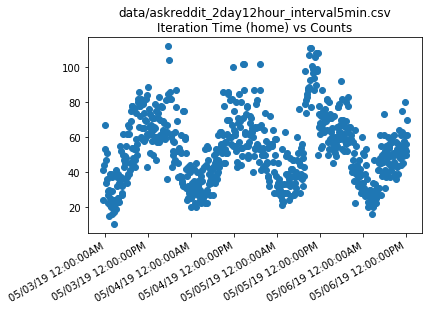

  built plot
    Build took: 0:00:00.358459

 === ITERATION TIME (UTC) === 
starting analyze
loading data
  loaded data
building plot


  built plot
    Build took: 0:00:00.196657

 === POST TIME (UTC) === 
starting analyze
loading data
  loaded data
building plot


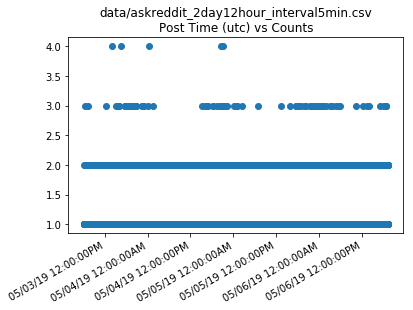

  built plot
    Build took: 0:00:00.499381

 === SUBREDDIT === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:01.011488

 === TITLE === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:01.231352

 === AUTHOR === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:00.666258

 === TOTAL KARMA === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:00.622420



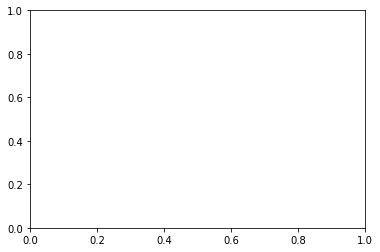

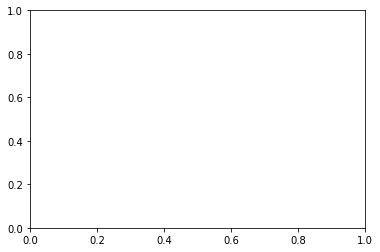

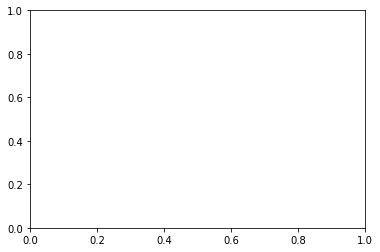

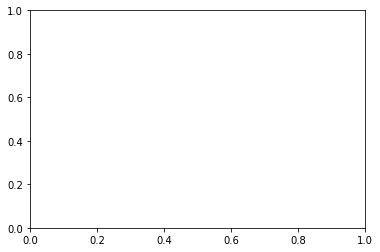

In [21]:
filename = "data/askreddit_2day12hour_interval5min.csv" # most important with coolest findings
makePlots(filename)

In [ ]:
filename = "data/askreddit_2day12hour_stream.csv", 
makePlots(filename)

 === ITERATION TIME (HOME) === 
starting analyze
loading data
  loaded data
building plot


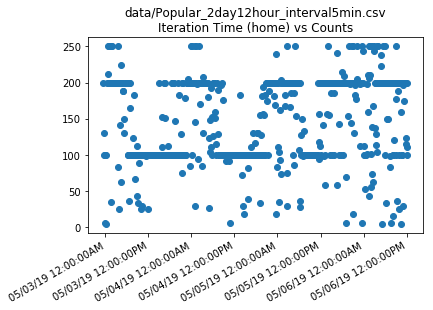

  built plot
    Build took: 0:00:00.178269

 === ITERATION TIME (UTC) === 
starting analyze
loading data
  loaded data
building plot


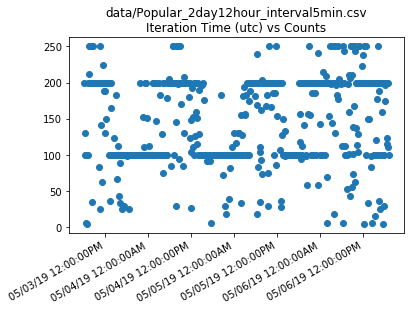

  built plot
    Build took: 0:00:00.721355

 === POST TIME (UTC) === 
starting analyze
loading data
  loaded data
building plot


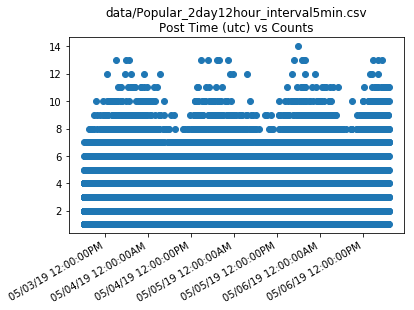

  built plot
    Build took: 0:00:00.449445

 === SUBREDDIT === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:00.511581

 === TITLE === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:01.722010

 === AUTHOR === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:00.916640

 === TOTAL KARMA === 
starting analyze
loading data
  loaded data
building plot
  built plot
    Build took: 0:00:00.555744



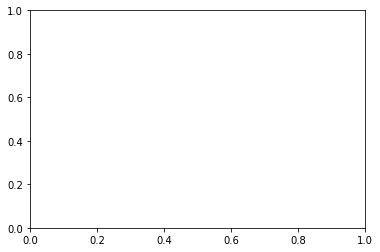

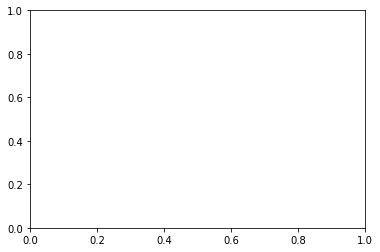

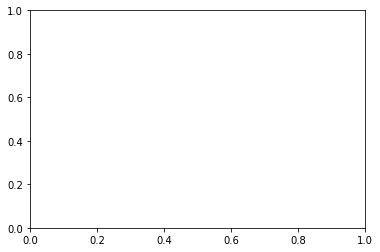

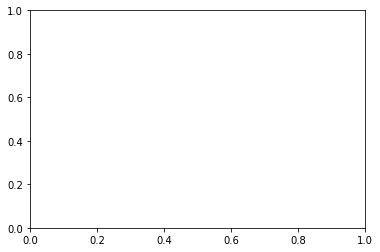

In [22]:
filename = "data/Popular_2day12hour_interval5min.csv"  # second coolest one
makePlots(filename)

In [ ]:
filename = "data/popular_2day12hour_stream.csv",    
makePlots(filename)

In [ ]:
filename = "data/ucsc_2day12hour_interval5min.csv"
makePlots(filename)

In [ ]:
filename = "data/ucsc_2day12hour_stream.csv"
makePlots(filename)

In [ ]:
# demo loading a Pickled Fig (only the matplotlib ones are pickled)

# all 26 figs are pickled and ready to be eaten, um, shown
# will use the figure make for the iteration time home for the a 30 min run 


# pickedFigName = creeatePickledName("30min_popular_5minInt.csv", "Iteration Time (home)")
# loadPickledFig(pickedFigName)


# AttributeError: module 'ipykernel.pylab.backend_inline' has no attribute 'new_figure_manager_given_figure'
# turns out this doesnt work on the notbook, works on my laptop though! 


# demo on local 